In [2]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [3]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)


In [11]:
# Split dataset into training (classes 0–7) and testing (classes 8–9)
train_classes = [mnist_train[i] for i in range(len(mnist_train)) if mnist_train[i][1] < 5]
test_classes = [mnist_test[i] for i in range(len(mnist_test)) if mnist_test[i][1] >= 5]

In [12]:
# Sampling support and query sets
def sample_episode(data, n_way, k_shot, query_per_class):
    sampled_classes = np.random.choice(np.unique([label for _, label in data]), n_way, replace=False)
    support_set, query_set = [], []
    for cls in sampled_classes:
        cls_data = [(x, y) for x, y in data if y == cls]
        sampled_data = np.random.choice(len(cls_data), k_shot + query_per_class, replace=False)
        support_set.extend([cls_data[i] for i in sampled_data[:k_shot]])
        query_set.extend([cls_data[i] for i in sampled_data[k_shot:]])
    return support_set, query_set

In [13]:
# Define the prototypical network
class ProtoNet(nn.Module):
    def __init__(self):
        super(ProtoNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
    def forward(self, x):
        return self.encoder(x).view(x.size(0), -1)

Training Progress:   0%|          | 0/100 [00:00<?, ?episode/s]

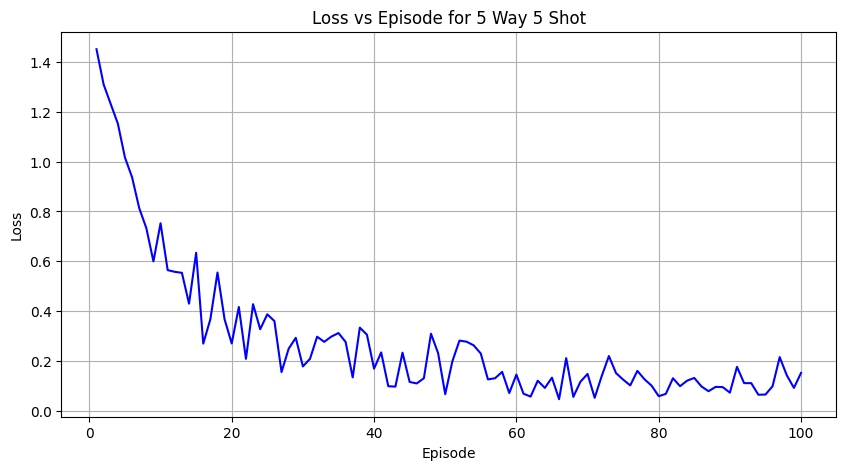

In [14]:
# Initialize model, optimizer, and loss function
model = ProtoNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_episodes = 100
n_way = 5
k_shot = 5

# Initialize list to track losses
losses = []

# Training loop with tqdm progress bar
with tqdm(total=num_episodes, desc="Training Progress", unit="episode") as pbar:
    for episode in range(num_episodes):
        support, query = sample_episode(train_classes, n_way=n_way, k_shot=k_shot, query_per_class=15)
        support_images = torch.stack([x[0] for x in support])
        query_images = torch.stack([x[0] for x in query])
        support_labels = torch.tensor([x[1] for x in support])
        query_labels = torch.tensor([x[1] for x in query])

        # Forward pass
        support_embeddings = model(support_images)
        query_embeddings = model(query_images)

        # Compute prototypes and remap labels
        unique_classes = torch.unique(support_labels)  # Unique classes in the episode
        prototypes = []
        class_to_idx = {cls.item(): idx for idx, cls in enumerate(unique_classes)}  # Map class -> index
        for cls in unique_classes:
            cls_embeddings = support_embeddings[support_labels == cls]
            prototypes.append(cls_embeddings.mean(dim=0))
        prototypes = torch.stack(prototypes)

        query_labels = torch.tensor([class_to_idx[label.item()] for label in query_labels])

        # Compute distances and classify
        dists = torch.cdist(query_embeddings, prototypes)  # Shape: (query_size, n_way)

        # Compute loss and backpropagate
        loss = nn.CrossEntropyLoss()(-dists, query_labels)  # Negate distances for softmax
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Store the loss value
        losses.append(loss.item())

        # Update tqdm progress bar
        pbar.set_postfix({"Loss": loss.item()})
        pbar.update(1)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_episodes + 1), losses, linestyle='-', color='b')
plt.title(f"Loss vs Episode for {n_way} Way {k_shot} Shot")
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.grid()
plt.show()

In [16]:
def evaluate(model, test_classes, n_way, k_shot, query_per_class, num_episodes):
    model.eval()  # Set model to evaluation mode
    accuracies = []
    
    with torch.no_grad():  # No gradient computation during testing
        for episode in range(num_episodes):
            # Sample support and query sets
            support, query = sample_episode(test_classes, n_way, k_shot, query_per_class)
            support_images = torch.stack([x[0] for x in support])
            query_images = torch.stack([x[0] for x in query])
            support_labels = torch.tensor([x[1] for x in support])
            query_labels = torch.tensor([x[1] for x in query])

            # Forward pass
            support_embeddings = model(support_images)
            query_embeddings = model(query_images)

            # Compute prototypes
            unique_classes = torch.unique(support_labels)
            prototypes = []
            class_to_idx = {cls.item(): idx for idx, cls in enumerate(unique_classes)}
            for cls in unique_classes:
                cls_embeddings = support_embeddings[support_labels == cls]
                prototypes.append(cls_embeddings.mean(dim=0))
            prototypes = torch.stack(prototypes)

            # Remap query labels
            query_labels = torch.tensor([class_to_idx[label.item()] for label in query_labels])

            # Classify query samples
            dists = torch.cdist(query_embeddings, prototypes)  # Compute distances
            preds = dists.argmin(dim=1)  # Predicted class is the one with minimum distance

            # Calculate accuracy for the episode
            accuracy = (preds == query_labels).float().mean().item()
            accuracies.append(accuracy)
    
    # Calculate average accuracy across episodes
    avg_accuracy = np.mean(accuracies)
    print(f"Average Accuracy over {num_episodes} test episodes: {avg_accuracy * 100:.2f}%")
    return avg_accuracy

# Test the model
avg_accuracy = evaluate(
    model,
    test_classes,
    n_way=5,  # Test with n-way tasks
    k_shot=k_shot,  # Test with k-shot learning
    query_per_class=15,
    num_episodes=100  # Test on 100 tasks
)

Average Accuracy over 100 test episodes: 83.41%
